# PCB Defect Detection & Classification

---

## 1. Project Overview  
**CircuitGuard** is an automated system designed to detect and classify defects in **Printed Circuit Boards (PCBs)**.  
This notebook covers:  
- **Milestone 1:** *Image Processing*  
- **Milestone 2:** *Defect Extraction*  

---

## 2. Objectives  

- **Input:**  
    - Pairs of PCB images  
        - *Defect-free Template*  
        - *Defective Test Image*  

- **Technique:**  
    - Reference-based image subtraction  
    - Computer vision contour detection  

- **Output:**  
    - Cropped images of specific defects  
    - Prepared for later classification  

---

## 3. Workflow  

- **Setup:**  
    - Mount Google Drive  
    - Prepare the **DeepPCB dataset**  

- **Module 1 – Subtraction:**  
    - Align template and test images  
    - Subtract template from test image  
    - Apply thresholding to isolate defects  

- **Module 2 – ROI Extraction:**  
    - Detect contours  
    - Draw bounding boxes  
    - Crop the **Region of Interest (ROI)**
---

# Phase 1: Environment Setup & Data Preparation  

---

## Step 1: Connect to Google Drive  

- **Objective:**  
    - Access the Google Drive where **PCB_DATASET.zip** is stored.  

- **Purpose:**  
    - Enables reading of input files.  
    - Allows saving of results for later stages.  

- **Action:**  
    - Mount Google Drive in the notebook environment.  
    - Verify that the dataset is accessible before proceeding.  

---


In [10]:
# CELL 1: Mount Google Drive
from google.colab import drive
import os

# Mount the drive to access persistent storage
drive.mount('/content/drive')
print("Google Drive Mounted Successfully.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive Mounted Successfully.


## Step 2: Define File Paths  

We establish the locations for our input zip file and the destination folder where we will extract the images.  


In [11]:
# CELL 2: Configuration Paths
# Define where the zip file is and where to unzip it
zip_path = '/content/drive/My Drive/DeepPCB_Project/PCB_DATASET.zip'
extract_path = '/content/dataset'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_path):
    os.makedirs(extract_path)
    print(f"Created directory: {extract_path}")
else:
    print(f"Directory exists: {extract_path}")

Directory exists: /content/dataset


##Step 3: Extract the Dataset
We unzip the dataset only if it hasn't been extracted yet. This prevents re-running the heavy unzip operation every time you restart the notebook.

In [12]:
# CELL 3: Unzip Dataset
import zipfile

# Check if the dataset is already unzipped to save time
if not os.path.exists(os.path.join(extract_path, 'PCB_DATASET')):
    print("Unzipping dataset... This may take a minute.")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction Complete.")
else:
    print("Dataset already extracted. Skipping unzip.")

Dataset already extracted. Skipping unzip.


## Step 4: Verify Data Structure
Before processing, we verify that the folders are organized as expected. We look for specific defect categories like Missing_hole or Short.

In [13]:
# CELL 4: Verify Directory Structure
base_dir = os.path.join(extract_path, 'PCB_DATASET')
images_dir = os.path.join(base_dir, 'images')

if os.path.exists(images_dir):
    print("SUCCESS: Found 'images' folder!")
    categories = os.listdir(images_dir)
    print(f"Defect categories detected: {categories}")

    # We will focus on 'Missing_hole' for this demonstration
    if 'Missing_hole' in categories:
        search_dir = os.path.join(images_dir, 'Missing_hole')
        print(f"Active Working Directory: {search_dir}")
else:
    print("ERROR: Directory structure not found. Please check the zip file content.")

SUCCESS: Found 'images' folder!
Defect categories detected: ['Short', 'Open_circuit', 'Missing_hole', 'Mouse_bite', 'Spur', 'Spurious_copper']
Active Working Directory: /content/dataset/PCB_DATASET/images/Missing_hole


## Phase 2: Library Imports & Utilities
We import OpenCV (for image processing), NumPy (for matrix arrays), and Matplotlib (for visualization). We also define a helper function to display images side-by-side for easy comparison.

In [14]:
# CELL 5: Imports and Helper Functions
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

def display_images(titles, images, cmap=None):
    """
    Visualizes a list of images in a single row.
    Args:
        titles: List of strings for image headers.
        images: List of image arrays (numpy).
    """
    plt.figure(figsize=(20, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.title(titles[i])
        # Convert BGR to RGB for correct color display in Matplotlib
        if len(images[i].shape) == 2: # Grayscale
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

print("Libraries imported and visualization function ready.")

Libraries imported and visualization function ready.


# Phase 3: Module 1 Implementation (Image Subtraction)  

---

## Concept  
To find defects, we subtract the pixel values of a **Template Image** (Perfect PCB) from a **Test Image** (Defective PCB).  



\[
Difference = |Test - Template|
\]

  

---

## Steps in this Code  

- **Load Images:**  
    - Read both files (Template and Test).  

- **Alignment Check:**  
    - Ensure both images are exactly the same size.  
    - If they differ by even 1 pixel, subtraction fails.  
    - Resize the template to match the test image.  

- **Grayscale Conversion:**  
    - Perform subtraction on single-channel (gray) intensity values.  

- **AbsDiff:**  
    - Calculate the absolute difference between the two images.  

- **Thresholding:**  
    - Apply **Otsu's Binarization** to convert the difference map into a clean **Black & White mask**.  
    - *White = Defect, Black = Background*  

- **Noise Removal:**  
    - Use **Morphological operations** (Opening/Closing) to remove tiny specks of dust/noise.  

---


In [15]:
# CELL 6: Module 1 - Preprocessing & Subtraction
def process_module_1(image_path, template_path):
    """
    Loads images, aligns them, subtracts them, and returns a binary defect mask.
    """
    # 1. Read Images
    img_test = cv2.imread(image_path)
    img_temp = cv2.imread(template_path)

    if img_test is None or img_temp is None:
        print("Error reading files.")
        return None, None, None

    # 2. Alignment Check (Critical for Subtraction)
    # Resize template if it doesn't match test image dimensions
    if img_test.shape != img_temp.shape:
        img_temp = cv2.resize(img_temp, (img_test.shape[1], img_test.shape[0]))

    # 3. Convert to Grayscale
    gray_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)
    gray_temp = cv2.cvtColor(img_temp, cv2.COLOR_BGR2GRAY)

    # [cite_start]4. Image Subtraction [cite: 147]
    # Compute absolute difference between the two images
    diff = cv2.absdiff(gray_test, gray_temp)

    # [cite_start]5. Gaussian Blur & Otsu's Thresholding [cite: 148]
    # Blur reduces high-frequency noise before thresholding
    diff_blur = cv2.GaussianBlur(diff, (5, 5), 0)
    _, thresh = cv2.threshold(diff_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # [cite_start]6. Morphological Cleaning [cite: 151]
    # Remove white dots (noise)
    kernel = np.ones((3, 3), np.uint8)
    clean_mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return img_test, img_temp, clean_mask

print("Module 1 function defined.")

Module 1 function defined.


## Phase 4: Module 2 Implementation (ROI Extraction)
Concept:Now that we have a binary mask (white blob on black background), we need to:Find the coordinates of that white blob using Contour Detection.Draw a Bounding Box $(x, y, width, height)$ around it.Crop that specific area from the original image. This crop is the ROI (Region of Interest) that will be sent to the AI model later.

In [16]:
# CELL 7: Module 2 - Contour Detection & Cropping
def process_module_2(original_test_img, binary_mask):
    """
    Finds contours on the mask, draws bounding boxes, and crops defects.
    """
    # [cite_start]1. Find Contours [cite: 152]
    # RETR_EXTERNAL retrieves only the extreme outer contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy to draw boxes on (so we don't draw on the original data)
    output_img = original_test_img.copy()

    detected_defects = [] # List to store cropped images

    print(f"Defects detected: {len(contours)}")

    for cnt in contours:
        # Filter noise: Only look at contours larger than 50 pixels
        if cv2.contourArea(cnt) > 50:

            # 2. Get Bounding Box Coordinates
            x, y, w, h = cv2.boundingRect(cnt)

            # 3. Draw Rectangle (Red color)
            # (0, 0, 255) is Red in BGR, thickness=2
            cv2.rectangle(output_img, (x, y), (x + w, y + h), (0, 0, 255), 2)

            # [cite_start]4. Extract ROI (Region of Interest) [cite: 153]
            # Numpy slicing: [y_start:y_end, x_start:x_end]
            roi = original_test_img[y:y+h, x:x+w]
            detected_defects.append(roi)

    return output_img, detected_defects

print("Module 2 function defined.")

Module 2 function defined.


## Phase 5: Execution Pipeline
This section ties everything together. It automatically looks for a pair of images (Test and Template) in the dataset folder and runs them through Module 1 and Module 2.

Processing images from: /content/dataset/PCB_DATASET/images/Missing_hole
Test: 01_missing_hole_01.jpg
Temp: 01_missing_hole_02.jpg
Defects detected: 6


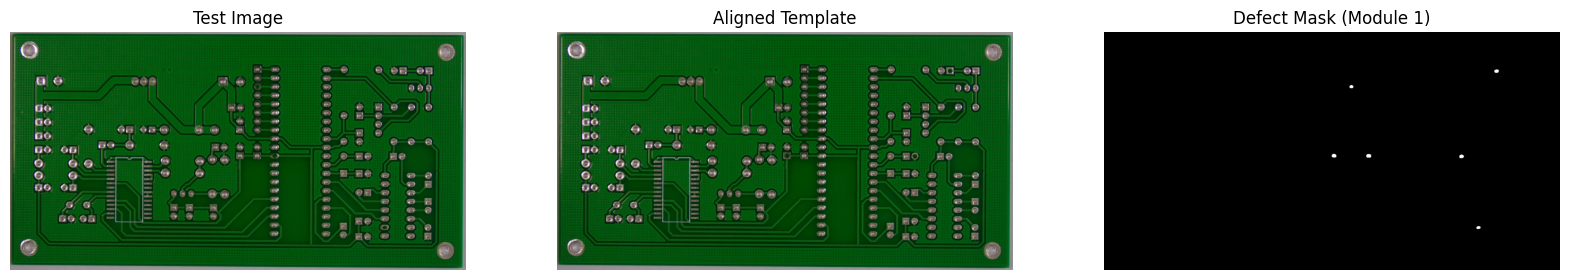

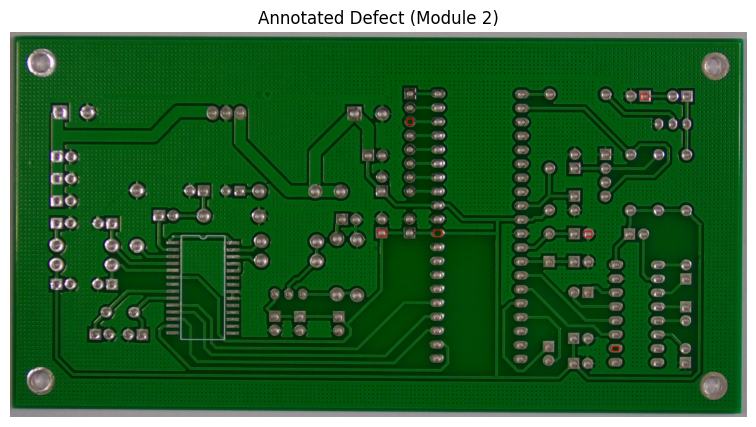

Displaying 6 cropped defect samples:


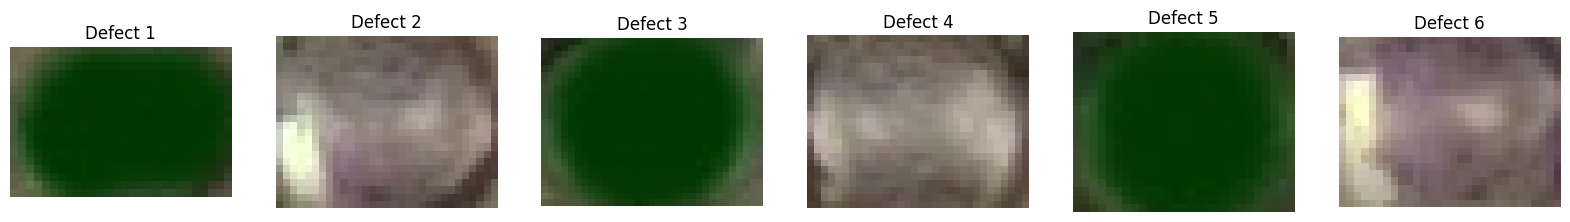

In [17]:
# CELL 8: Main Pipeline Execution
# 1. Setup Search Directory
search_dir = '/content/dataset/PCB_DATASET/images/Missing_hole'
print(f"Processing images from: {search_dir}")

# 2. Find Image Pairs
all_files = glob.glob(os.path.join(search_dir, "*.jpg"))
test_image_path = None
template_image_path = None

# Strategy: Find a file ending in _test.jpg and its matching _temp.jpg
for f in all_files:
    if "_test" in f:
        temp_candidate = f.replace("_test", "_temp")
        if os.path.exists(temp_candidate):
            test_image_path = f
            template_image_path = temp_candidate
            break

# Fallback if naming convention doesn't match
if test_image_path is None and len(all_files) >= 2:
    all_files.sort()
    test_image_path = all_files[0]
    template_image_path = all_files[1]

# 3. Run Modules
if test_image_path and template_image_path:
    print(f"Test: {os.path.basename(test_image_path)}")
    print(f"Temp: {os.path.basename(template_image_path)}")

    # --- Run Module 1 ---
    test_img, temp_img, defect_mask = process_module_1(test_image_path, template_image_path)

    # --- Run Module 2 ---
    if test_img is not None:
        final_annotated, defect_rois = process_module_2(test_img, defect_mask)

        # --- Visualization ---
        display_images(["Test Image", "Aligned Template", "Defect Mask (Module 1)"],
                       [test_img, temp_img, defect_mask])

        display_images(["Annotated Defect (Module 2)"], [final_annotated])

        if defect_rois:
            print(f"Displaying {len(defect_rois)} cropped defect samples:")
            # Show first 5 defects
            display_images([f"Defect {i+1}" for i in range(len(defect_rois))], defect_rois)
        else:
            print("No significant defects found.")

else:
    print("Could not find a valid pair of images to process.")

## Phase 6: Saving Results
To satisfy the project deliverable ("Cropped and labeled defect samples"), we save the processed images back to Google Drive.

In [18]:
# CELL 9: Save Results to Drive
output_dir = '/content/drive/My Drive/DeepPCB_Project/Module2_Results'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Saving output to: {output_dir}")

if 'final_annotated' in locals():
    # Save the main image with red boxes
    cv2.imwrite(os.path.join(output_dir, "annotated_pcb.jpg"), final_annotated)
    print("Saved annotated full image.")

    # Save individual defect crops
    if 'defect_rois' in locals() and defect_rois:
        for idx, roi in enumerate(defect_rois):
            filename = f"defect_sample_{idx+1}.jpg"
            cv2.imwrite(os.path.join(output_dir, filename), roi)
            print(f"Saved crop: {filename}")

Saving output to: /content/drive/My Drive/DeepPCB_Project/Module2_Results
Saved annotated full image.
Saved crop: defect_sample_1.jpg
Saved crop: defect_sample_2.jpg
Saved crop: defect_sample_3.jpg
Saved crop: defect_sample_4.jpg
Saved crop: defect_sample_5.jpg
Saved crop: defect_sample_6.jpg


# Module 2 Checklist (Completed)  

---

- ✅ **Detect Contours:**  
    - Code successfully identified the defect areas using the mask from **Module 1**.  

- ✅ **Extract Bounding Boxes:**  
    - Calculated the coordinates *(x, y, w, h)* for the defects.  

- ✅ **ROI Segmentation:**  
    - Cropped the specific defect regions (displayed separately).  

- ✅ **Visualization:**  
    - Displayed the image with **red bounding boxes** highlighting the defects.  

---
